In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual, HBox, Layout,VBox
import ipywidgets as widgets

Reading in Disaster Dataset

In [2]:
import warnings
warnings.filterwarnings("ignore")

# DISASTER DATASET
disaster_data_link = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/DisasterDeclarationsSummaries.csv'

#create dataframe from FEMA disaster declarations summaries csv
file = pd.read_csv(disaster_data_link, low_memory=False)
df = pd.DataFrame(file)

#dictionary to convert state/territory designators to full word strings
state_dict = {'AL':'Alabama','AK':'Alaska','AZ':'Arizona','AR':'Arkansas','CA':'California','CO':'Colorado','CT':'Connecticut',
             'DE':'Delaware', 'FL':'Florida','GA':'Georgia','HI':'Hawaii','ID':'Idaho','IL':'Illinois','IN':'Indiana','IA':'Iowa',
             'KS':'Kansas','KY':'Kentucky','LA':'Louisiana','ME':'Maine','MD':'Maryland','MA':'Massachusetts','MI':'Michigan',
             'MN':'Minnesota','MS':'Mississippi','MO':'Missouri','MT':'Montana','NE':'Nebraska','NV':'Nevada','NH':'New Hampshire',
             'NM':'New Mexico','NY':'New York','NJ':'New Jersey','NC':'North Carolina','ND':'North Dakota','OH':'Ohio',
             'OK':'Oklahoma','OR':'Oregon','PA':'Pennsylvania','RI':'Rhode Island','SC':'South Carolina','SD':'South Dakota',
              'TN':'Tennessee','TX':'Texas','UT':'Utah','VT':'Vermont','VA':'Virginia','WA':'Washington','WV':'West Virginia',
             'WI':'Wisconsin','WY':'Wyoming','DC':'Washington, DC','GU':'Guam','PR':'Puerto Rico','AS':'American Samoa',
             'MP':'Northern Mariana Islands','FM':'Federated States of Micronesia','MH':'Marshall Islands','PW':'Palau'}

#create a list of the 48 contiguous states.  Alaska, Hawaii, DC, and territories are omitted
state_list = ['AL','AZ','AR','CA','CO','CT','DE', 'FL','GA','ID','IL','IN','IA','KS','KY','LA','ME','MD','MA','MI',
             'MN','MS','MO','MT','NE','NV','NH','NM','NY','NJ','NC','ND','OH','OK','OR','PA','RI','SC','SD',
              'TN','TX','UT','VT','VA','WA','WV','WI','WY']

#set using only natural disasters that could be potentially caused by climate change
natural_disaster = ['Fire','Flood','Severe Storm','Straight-Line Winds','Winter Storm','Hurricane','Tornado','Tropical Storm',
                   'Mud/Landslide','Snowstorm','Coastal Storm','Severe Ice Storm','Typhoon','Freezing','Drought','Fishing Losses',
                   'Other', 'Dam/Levee Break','Tropical Depression']

#manmade or other disasters that would not be caused by climate change
nonweather_disaster = ['Earthquake','Other','Biological','Dam/Levee Break','Volcanic Eruption','Toxic Substances','Chemical',
                      'Terrorist','Human Cause','Tsunami','Civil Unrest','Nuclear','Explosion','Tidal Wave']

#dictionary to convert disaster codes to strings representing each type of disaster
disaster_dict = {'0':'Not applicable','1':'Explosion','2':'Straight-Line Winds','3':'Tidal Wave','4':'Tropical Storm',
                '5':'Winter Storm','A':'Tsunami','B':'Biological','C':'Coastal Storm','D':'Drought','E':'Earthquake',
                 'F':'Flood','G':'Freezing','H':'Hurricane','I':'Terrorist','J':'Typhoon','K':'Dam/Levee Break','L':'Chemical',
                'M':'Mud/Landslide','N':'Nuclear','O':'Severe Ice Storm','P':'Fishing Losses','Q':'Crop Losses','R':'Fire',
                'S':'Snowstorm','T':'Tornado','U':'Civil Unrest', 'V':'Volcanic Eruption','W':'Severe Storm','X':'Toxic Substances',
                'Y':'Human Cause','Z':'Other', '8':'Tropical Depression'}


                #select columns necessary for data analysis, add empty columns for each natural disaster type
column_list = ['femaDeclarationString','state','incidentType','incidentBeginDate','fipsStateCode','region',
               'designatedIncidentTypes','declarationTitle']+natural_disaster
df = df.reindex(columns=column_list, fill_value=0)


#convert strings to datetime objects
df['incidentBeginDate']=pd.to_datetime(df['incidentBeginDate'])


#create columns for year, month, and day for later analysis
df['year'] = df['incidentBeginDate'].dt.year
df['month'] = df['incidentBeginDate'].dt.month
df['day'] = df['incidentBeginDate'].dt.day


#select only disasters where primary incident type is in the natural disaster list, only states in CONUS, and only
#in range 1953-2023
disaster_df = df[(df['incidentType'].isin(natural_disaster)) & (df['state'].isin(state_list)) 
& (df['year'].isin(range(1953,2024)))]

disaster_df.reset_index(inplace = True)


#fill in the missing values in the designatedIncidentTypes column using the indicidentType column
disaster_df['designatedIncidentTypes'].fillna(disaster_df['incidentType'], inplace = True)


#this block uses the incident codes in disaster_dict to populate the respective incident columns in disaster_df
for i in range(0,len(disaster_df)):
    incident = disaster_df.loc[i,'designatedIncidentTypes']
    incident_list = incident.split(',')
    
    #if there is only one incident type, add 1 to the corresponding column
    if ((len(incident_list) == 1) & (len(incident_list[0])>1)):
        col = incident_list[0]
        try:
            disaster_df.loc[i, col] += 1
        except:
            continue

    #if there are multiple incident types, add 1 to the corresponding column for each
    else:
        #create a new list, this combines the incident list from designatedIncidentTypes and incidentType
        new_list = []
        for inc in incident_list:
            #add longform name to new_list
            if len(inc) == 1:
                new_list.append(disaster_dict[inc])
        #add incidentType to new_list if not already in new_list        
        if disaster_df.loc[i, 'incidentType'] not in new_list:
            new_list.append(disaster_df.loc[i, 'incidentType'])
        #ensures that code skips over non-natural disasters        
        for val in new_list:
            try:
                disaster_df.loc[i, val] += 1
            except: 
                continue


#drop duplicate disaster declarations, this eliminates duplicate county declarations in each state
disaster_df.drop_duplicates('femaDeclarationString', inplace = True)
disaster_merge_df = disaster_df.drop(columns=['index', 'incidentType','femaDeclarationString','incidentBeginDate','designatedIncidentTypes','declarationTitle','day'])
disaster_merge_df['state'].replace(to_replace=state_dict, inplace=True)


#create a dataframe from groupby that totals the disasters for each month by state.  
#this is for state-level analysis only.  do not use for region or national level analysis.

'''
disaster_group = disaster_merge_df.groupby(by=['year','month','state']).agg(fire = ('Fire','sum'),
                                                                 flood = ('Flood','sum'),
                                                                  severe = ('Severe Storm','sum'),
                                                                  straight_line_winds= ('Straight-Line Winds','sum'),
                                                                  winter_storm = ('Winter Storm','sum'),
                                                                  hurricane = ('Hurricane','sum'),
                                                                  tornado = ('Tornado','sum'),
                                                                  tropical_storm = ('Tropical Storm','sum'),
                                                                  landslide = ('Mud/Landslide','sum'),
                                                                  snowstorm = ('Snowstorm','sum'),
                                                                  coastal_storm = ('Coastal Storm','sum'),
                                                                  ice_storm = ('Severe Ice Storm','sum'),
                                                                  typhoon = ('Typhoon','sum'),
                                                                  freezing = ('Freezing','sum'),
                                                                  drought = ('Drought','sum'),
                                                                  fishing_loss = ('Fishing Losses','sum'),
                                                                   other = ('Other','sum'), 
                                                                  dam_break = ('Dam/Levee Break','sum'),
                                                                  tropical_depression = ('Tropical Depression','sum')
                                                                 )

'''

disaster_group = disaster_merge_df.drop(['fipsStateCode', 'region'], axis=1).groupby(['year','month','state']).sum()
#disaster_group = disaster_group.reset_index().groupby(['year','month','state']).sum()

In [3]:
"""

# revised disaster_group dataframe addressing the issue about region code disappering from previous grouping 
# this approach should return the same data 
disaster_group = disaster_merge_df.groupby(['year','month','state', 'region']).sum().drop('fipsStateCode', axis=1)
disaster_group = disaster_group.reset_index().groupby(['year','month','state']).sum()
disaster_group['region'] = disaster_group['region'].astype(str)

"""

"\n\n# revised disaster_group dataframe addressing the issue about region code disappering from previous grouping \n# this approach should return the same data \ndisaster_group = disaster_merge_df.groupby(['year','month','state', 'region']).sum().drop('fipsStateCode', axis=1)\ndisaster_group = disaster_group.reset_index().groupby(['year','month','state']).sum()\ndisaster_group['region'] = disaster_group['region'].astype(str)\n\n"

Read in Weather Dataset 

In [4]:
#WEATHER DATASET

# collections of data URLs 

# Direct Link to NCEI Website, currently down as of 09/30/24
"""
data_url_percipitation = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pcpnst-v1.0.0-20240906'
data_url_max_temp = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmaxst-v1.0.0-20240906'
data_url_min_temp = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tminst-v1.0.0-20240906'
data_url_avg_temp = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-tmpcst-v1.0.0-20240906'
data_url_phdi = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-phdist-v1.0.0-20240906'
data_url_pdmi = 'https://www.ncei.noaa.gov/pub/data/cirs/climdiv/climdiv-pmdist-v1.0.0-20240906'
data_url_pdsi = 'https://www.ncei.noaa.gddov/pub/data/cirs/climdiv/climdiv-pdsist-v1.0.0-20240906'
"""

# Backup Dataset in Github 
data_url_percipitation = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-pcpnst'
data_url_max_temp = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-tmaxst'
data_url_min_temp = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-tminst'
data_url_avg_temp = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-tmpcst'
data_url_phdi = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-phdist'
data_url_pdmi = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-pmdist'
data_url_pdsi = 'https://raw.githubusercontent.com/xquinnma/milestone/refs/heads/main/weather_data/climdiv-pdsist'


# column names for the data URLs - Month 1 to 12
data_column_names = ['id', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# dictionary for state code and state names 
state_code_dict = {
    '1':'Alabama', '2':'Arizona', '3':'Arkansas', '4':'California', '5':'Colorado',
    '6':'Connecticut', '7':'Delaware', '8':'Florida', '9':'Georgia', '10':'Idaho',
    '11':'Illinois', '12':'Indiana', '13':'Iowa', '14':'Kansas', '15':'Kentucky',
    '16':'Louisiana', '17':'Maine', '18':'Maryland', '19':'Massachusetts', '20':'Michigan',
    '21':'Minnesota', '22':'Mississippi', '23':'Missouri', '24':'Montana', '25':'Nebraska',
    '26':'Nevada', '27':'New Hampshire', '28':'New Jersey', '29':'New Mexico', '30':'New York',
    '31':'North Carolina', '32':'North Dakota', '33':'Ohio', '34':'Oklahoma', '35':'Oregon',
    '36':'Pennsylvania', '37':'Rhode Island', '38':'South Carolina', '39':'South Dakota', '40':'Tennessee',
    '41':'Texas', '42':'Utah', '43':'Vermont', '44':'Virginia', '45':'Washington',
    '46':'West Virginia', '47':'Wisconsin', '48':'Wyoming'
                   }



#fucntion that cleans data

def format_df(input_url, feature_name, start_year=1953, end_year=2023):
    df = pd.read_csv(input_url, header=None, names=data_column_names, delimiter=r"\s+", dtype= str)
    df = df.set_index('id').stack().reset_index().rename(columns={'level_1':'month', 0:feature_name})

    # create columns for state code and year from id column
    # convert year and month to datetime data
    df['state_code'] = df['id'].astype(str).str[:3].astype(int)
    df['year'] = pd.to_datetime(df['id'].astype(str).str[-4:]).dt.year
    df['month'] = pd.to_datetime(df['month'], format='%m').dt.month
    
    # limit state code < 48 is continental US
    df = df[df['state_code'] < 49]
    # limit data between year 1953 and 2023
    df = df[(df['year'] >= start_year) & (df['year'] <= end_year)]

    # convert state code to state name 
    df['state'] = df['state_code'].astype(str).map(state_code_dict)

    # dropping unnecessary coloumns and shuffle column order and reset index
    df = df.drop(['id', 'state_code'], axis=1)
    
    # convert column to floats
    df = df.astype({feature_name : 'float'})
    
    # reorder columns
    df = df[['year', 'month', 'state', feature_name]].reset_index(drop=True)
    
    #print(df.dtypes)

    return df.copy()



# creating individual dataframes for each feature
df_percipitation = format_df(data_url_percipitation, 'percipitation')
df_max_temp =   format_df(data_url_max_temp, 'max_temp')
df_min_temp = format_df(data_url_min_temp, 'min_temp')
df_avg_temp = format_df(data_url_avg_temp, 'avg_temp')
df_phdi = format_df(data_url_phdi, 'pdhi')
df_phmi = format_df(data_url_pdmi, 'pdmi')

# combine all data 
df_all_list = [df_percipitation, df_max_temp, df_min_temp, df_avg_temp, df_phdi, df_phmi]

df_combined = df_all_list[0].copy()

for i in range(len(df_all_list)):
    if i!=0:
        df_combined = pd.merge(df_combined, df_all_list[i], on=['year', 'month', 'state'])


df_combined_grouped = df_combined.groupby(['year', 'month', 'state']).sum()


In [5]:
#COMBINE INTO ONE DATASET

weather_df = df_combined_grouped.copy()
disaster = disaster_group.copy()

full_df = (disaster.join(weather_df, how = 'outer'))
full_df.fillna(0, inplace = True)


# get possible regions codes from dataset 
states_region_df = disaster_merge_df[['state', 'region']].drop_duplicates()
region_codes = sorted(states_region_df.drop_duplicates()['region'].unique().tolist())

# build a dictionary of region codes and state names 
state_region_dict = {}
for i in region_codes:
    states_list = states_region_df[states_region_df['region']==i]['state'].values
    for j in states_list:
        state_region_dict[j] = str(i)

# adding region column back into the merged dataset
full_df = full_df.reset_index()
full_df['region'] = full_df['state'].map(state_region_dict)

# showing the full dataframe
full_df.groupby(['region','year','state']).sum().head(20)


month  Fire  Flood  Severe Storm  \
region year state                                             
1      1953 Connecticut       78   0.0    0.0           0.0   
            Maine             78   0.0    0.0           0.0   
            Massachusetts     78   0.0    0.0           0.0   
            New Hampshire     78   1.0    0.0           0.0   
            Rhode Island      78   0.0    0.0           0.0   
            Vermont           78   0.0    0.0           0.0   
       1954 Connecticut       78   0.0    1.0           0.0   
            Maine             78   0.0    1.0           0.0   
            Massachusetts     78   0.0    1.0           0.0   
            New Hampshire     78   0.0    0.0           0.0   
            Rhode Island      78   0.0    1.0           0.0   
            Vermont           78   0.0    0.0           0.0   
       1955 Connecticut       78   0.0    1.0           1.0   
            Maine             78   0.0    0.0           0.0   
            Massachusetts     78   0.0    1.0           0.0   
            New Hampshire     78   0.0    0.0           0.0   
            Rhode Island      78   0.0    1.0           0.0   
            Vermont           78   0.0    0.0           0.0   
       1956 Connecticut       78   0.0    0.0           0.0   
            Maine             78   0.0    0.0           0.0   

                           Straight-Line Winds  Winter Storm  Hurricane  \
region year state                                                         
1      1953 Connecticut                    0.0           0.0        0.0   
            Maine                          0.0           0.0        0.0   
            Massachusetts                  0.0           0.0        0.0   
            New Hampshire                  0.0           0.0        0.0   
            Rhode Island                   0.0           0.0        0.0   
            Vermont                        0.0           0.0        0.0   
       1954 Connecticut                    0.0           0.0        1.0   
            Maine                          0.0           0.0        1.0   
            Massachusetts                  0.0           0.0        1.0   
            New Hampshire                  0.0           0.0        0.0   
            Rhode Island                   0.0           0.0        1.0   
            Vermont                        0.0           0.0        0.0   
       1955 Connecticut                    0.0           0.0        1.0   
            Maine                          0.0           0.0        0.0   
            Massachusetts                  0.0           0.0        1.0   
            New Hampshire                  0.0           0.0        0.0   
            Rhode Island                   0.0           0.0        1.0   
            Vermont                        0.0           0.0        0.0   
       1956 Connecticut                    0.0           0.0        0.0   
            Maine                          0.0           0.0        0.0   

                           Tornado  Tropical Storm  Mud/Landslide  ...  \
region year state                                                  ...   
1      1953 Connecticut        0.0             0.0            0.0  ...   
            Maine              0.0             0.0            0.0  ...   
            Massachusetts      1.0             0.0            0.0  ...   
            New Hampshire      0.0             0.0            0.0  ...   
            Rhode Island       0.0             0.0            0.0  ...   
            Vermont            0.0             0.0            0.0  ...   
       1954 Connecticut        0.0             0.0            0.0  ...   
            Maine              0.0             0.0            0.0  ...   
            Massachusetts      0.0             0.0            0.0  ...   
            New Hampshire      0.0             0.0            0.0  ...   
            Rhode Island       0.0             0.0            0.0  ...   
            Vermont        

In [6]:
# define columns for weather data features and disaster type features 
weather_features = weather_df.columns.values.tolist()
disaster_features = disaster_group.columns.values.tolist()
other_features = ['year','month', 'state', 'region']

# reodering columns of the full_df
full_df = full_df[other_features + disaster_features  + weather_features]

In [7]:
#AVG TEMP OF THE NATION OVER YEARS

# plotting average temp by year to see the trend for global warming 

weather_df_by_year = full_df[other_features + weather_features].drop(['month', 'state','region'], axis=1).groupby('year').mean()

# drop down menu allowing to switch features 
@interact (features=weather_df_by_year.columns)
#@interact (features=avg_grouped_by_year.index)

def plot_features(features):
    fig, ax1 = plt.subplots(figsize=(15, 7))
    plt.title(str(features) + " trends between 1953 - 2023 CONUS")
    plt.plot(weather_df_by_year.index, weather_df_by_year[features])
    plt.show()

interactive(children=(Dropdown(description='features', options=('percipitation', 'max_temp', 'min_temp', 'avg_…

In [8]:
'''

# list of states and features 
list_of_features = weather_df.columns
list_of_states = weather_df.reset_index()['state'].unique()

# drop down menus of options 
state_selection = widgets.Dropdown(options=list_of_states, value=list_of_states[0], description='States:', disabled=False)
features_selection = widgets.Dropdown(options=list_of_features, value=list_of_features[0], description='Features:', disabled=False)

# fucntion to interatively draw graphs based on filters 
def draw_graph(selected_state, selected_feature):
    feature_data_per_state = weather_df.reset_index().drop('month', axis=1)
    feature_data_per_state = feature_data_per_state[feature_data_per_state['state'] == selected_state]
    feature_data_per_state = feature_data_per_state.drop('state', axis=1).groupby('year').mean()

    plt.title(selected_feature + " trend of between 1953 and 2023 in " + selected_state)
    plt.plot(feature_data_per_state.index, feature_data_per_state[selected_feature])

interactive(draw_graph, selected_state = state_selection, selected_feature = features_selection)


'''

'\n\n# list of states and features \nlist_of_features = weather_df.columns\nlist_of_states = weather_df.reset_index()[\'state\'].unique()\n\n# drop down menus of options \nstate_selection = widgets.Dropdown(options=list_of_states, value=list_of_states[0], description=\'States:\', disabled=False)\nfeatures_selection = widgets.Dropdown(options=list_of_features, value=list_of_features[0], description=\'Features:\', disabled=False)\n\n# fucntion to interatively draw graphs based on filters \ndef draw_graph(selected_state, selected_feature):\n    feature_data_per_state = weather_df.reset_index().drop(\'month\', axis=1)\n    feature_data_per_state = feature_data_per_state[feature_data_per_state[\'state\'] == selected_state]\n    feature_data_per_state = feature_data_per_state.drop(\'state\', axis=1).groupby(\'year\').mean()\n\n    plt.title(selected_feature + " trend of between 1953 and 2023 in " + selected_state)\n    plt.plot(feature_data_per_state.index, feature_data_per_state[selected_fe

In [9]:
# list of states and features 
list_of_features = weather_df.columns
list_of_states = weather_df.reset_index()['state'].unique()

# drop down menus of options 
state_selection = widgets.Dropdown(options=list_of_states, value=list_of_states[0], description='States:', disabled=False)
features_selection = widgets.Dropdown(options=list_of_features, value=list_of_features[0], description='Features:', disabled=False)

# fucntion to interatively draw graphs based on filters 
def draw_graph(selected_state, selected_feature):
    feature_data_per_state = weather_df.reset_index().drop('month', axis=1)
    feature_data_per_state = feature_data_per_state[feature_data_per_state['state'] == selected_state]
    feature_data_per_state = feature_data_per_state.drop('state', axis=1).groupby('year').mean()

    disaster_df_slice = full_df[other_features + disaster_features]
    disaster_df_slice = disaster_df_slice.drop(['month', 'region'], axis=1)
    disaster_total_occurance_df = disaster_df_slice.groupby(['year','state']).sum().T.sum()
    disaster_total_occurance_df = disaster_total_occurance_df.reset_index()
    disaster_total_occurance_df = disaster_total_occurance_df.rename(columns={0:'total_disaster_occurances'})
    disaster_total_occurance_per_state = disaster_total_occurance_df[disaster_total_occurance_df['state'] == selected_state]

    # set figure size 
    fig, ax1 = plt.subplots(figsize=(15, 7))
    #ax1.set_xlabel('year')
    ax1.set_ylabel(selected_feature)
    plt.title(selected_feature + " trend of between 1953 and 2023 in " + selected_state)
    # temperature line chart 
    plt.plot(feature_data_per_state.index, feature_data_per_state[selected_feature])
    ax1.tick_params(axis='y')

    # disaster occurance bar chart
    ax2 = ax1.twinx()
    plt.bar(disaster_total_occurance_per_state['year'], disaster_total_occurance_per_state['total_disaster_occurances'], color='orange', alpha=0.5)
    ax2.set_ylabel('total occurances of disasters')
    ax2.tick_params(axis='y')

# fixing layout options 
widget = interactive(draw_graph, selected_state = state_selection, selected_feature = features_selection)
menu = HBox(widget.children[:-1], layout = Layout(flex_flow='row wrap'))
graph = output = widget.children[-1]
display(VBox([menu, graph]))

In [10]:
total_disaster = full_df[other_features + disaster_features].drop(['month','state','region'], axis=1).groupby('year').sum().T.sum().reset_index().rename(columns={0:'disaster_occurance'})
total_disaster= total_disaster.set_index('year')

weather_df_avg_year = weather_df.reset_index().drop(['month','state'], axis=1).groupby('year').mean()

joined_disaster_weather = total_disaster.join(weather_df_avg_year)


features = widgets.Dropdown(options=weather_features, value=weather_features[0], description='Features:', disabled=False)

@interact (features=weather_features)

def plot_features(features):
    fig, ax1 = plt.subplots(figsize=(9, 7))
    plt.title('relation between ' + str(features) + ' and natural disaster occurances')
    a, b = np.polyfit(joined_disaster_weather['disaster_occurance'], joined_disaster_weather[features], 1)
    plt.scatter(joined_disaster_weather[features], joined_disaster_weather['disaster_occurance'])
    plt.plot( a*joined_disaster_weather+b, joined_disaster_weather)
    plt.show()

interactive(children=(Dropdown(description='features', options=('percipitation', 'max_temp', 'min_temp', 'avg_…

Stacked Bar Charts 

In [11]:
state_selection = widgets.Dropdown(options=list_of_states, value=list_of_states[0], description='States:', disabled=False)

@interact (features=state_selection)

def plot_features(features):

    plot_df = full_df[other_features + disaster_features].drop(['month','region'], axis=1)
    selected_df = plot_df[plot_df['state']==features].drop('state', axis=1).groupby('year').sum().reset_index()
    selected_df.plot(x='year', kind='bar', stacked=True, figsize=(17,7))
    plt.legend(loc='center left', bbox_to_anchor=(1,0.6))
    plt.show()

interactive(children=(Dropdown(description='States:', options=('Alabama', 'Arizona', 'Arkansas', 'California',…

EXPERIMENT

In [12]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import mapclassify as mc

In [13]:
# getting location dataset for the map plot 
contiguous_usa = gpd.read_file(gplt.datasets.get_path('contiguous_usa'))

plot_df = full_df[other_features + disaster_features].drop(['month','region'], axis=1)
selected_df = plot_df[plot_df['state']==features].drop('state', axis=1).groupby('year').sum().reset_index()

# geo data for map plotting 
conus_geo_data = contiguous_usa[['state','geometry']]
conus_geo_data_dict = {}

# dictionary for 
for i in conus_geo_data['state']:
    conus_geo_data_dict[i] = conus_geo_data[conus_geo_data['state']==i]['geometry'].values[0]

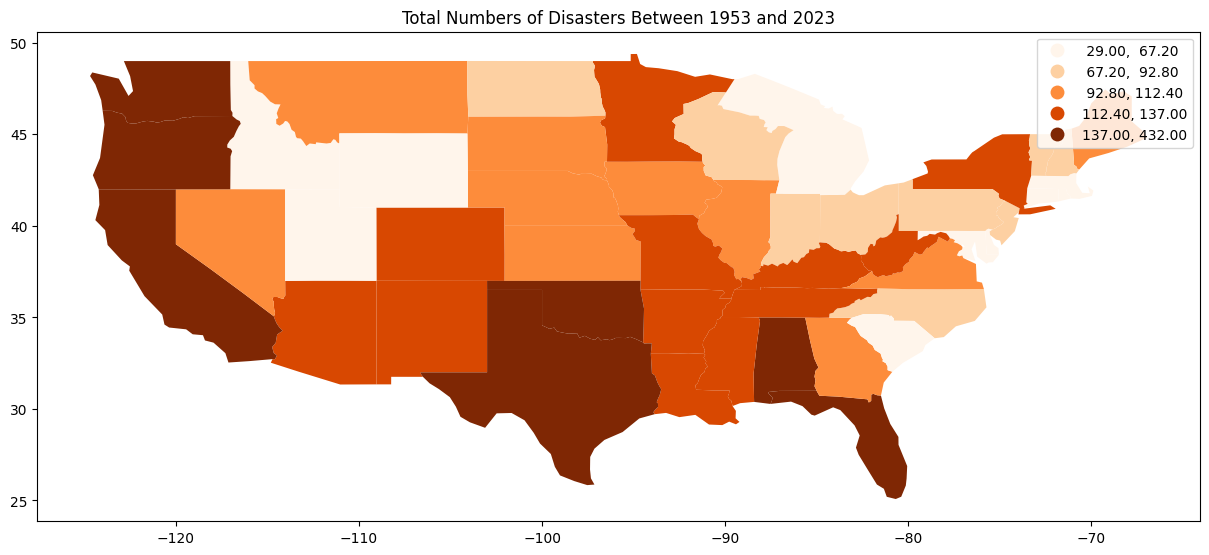

In [14]:
disaster_data_by_year_state = full_df[other_features + disaster_features].drop(['month','region'], axis=1).groupby(['year','state']).sum().T.sum()
disaster_data_by_year_state = disaster_data_by_year_state.reset_index().rename(columns={0:'total_disaster'})
disaster_data_by_state = disaster_data_by_year_state.groupby('state').sum().drop('year', axis=1).reset_index()
disaster_data_by_state['total_disaster'] = disaster_data_by_state['total_disaster'].astype(int)
disaster_data_by_state['geometry'] = disaster_data_by_state['state'].map(conus_geo_data_dict)

disaster_data_by_state_geo = gpd.GeoDataFrame(disaster_data_by_state)
fig= disaster_data_by_state_geo.plot(column='total_disaster', legend=True,scheme='quantiles', figsize=(15, 10), cmap="Oranges").set_title('Total Numbers of Disasters Between 1953 and 2023')
plt.show(fig)

Text(0.5, 1.0, 'Total Numbers of Disasters Between 1953 and 2023')

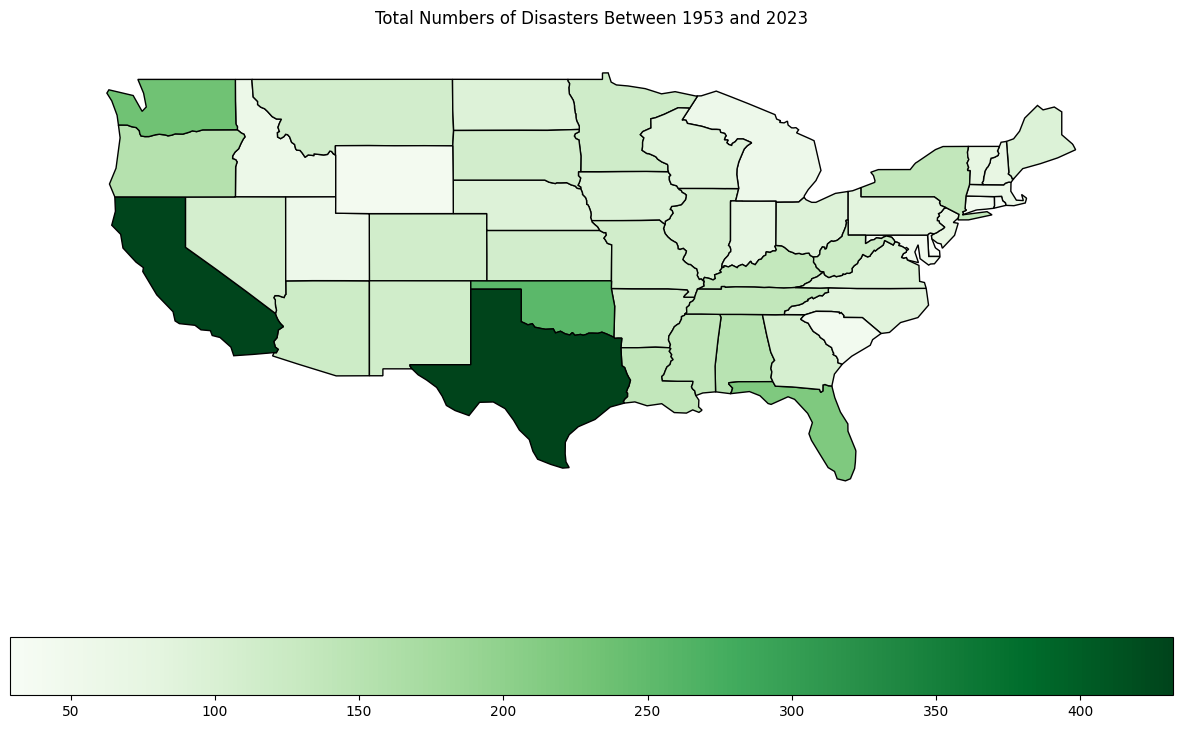

In [15]:
gplt.choropleth(
    disaster_data_by_state_geo, hue='total_disaster', cmap='Greens', legend=True, figsize=(15, 10), legend_kwargs={'orientation': 'horizontal'}
).set_title('Total Numbers of Disasters Between 1953 and 2023')

In [16]:
@interact(x=(1953,2023,1))
def h(x=1953):
    return x

interactive(children=(IntSlider(value=1953, description='x', max=2023, min=1953), Output()), _dom_classes=('wi…